In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

## Getting set up

In [2]:
comp = 'godaddy-microbusiness-density-forecasting'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
!ls godaddy-microbusiness-density-forecasting

census_starter.csv    test.csv
sample_submission.csv train.csv


Now we can import the stuff we'll need from fastai, set a seed (for reproducibility -- just for the purposes of making this notebook easier to write; I don't recommend doing that in your own analysis however) and check what's in the data:

In [4]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Looking at the data

In [5]:
df = pd.read_csv(path/'train.csv')

In [6]:
df['first_day_of_month'] =  pd.to_datetime(df['first_day_of_month'])

In [7]:
df_state_info = df[['cfips','county','state']].set_index('cfips').drop_duplicates()
county_one_hot = pd.get_dummies(df_state_info.county)
state_one_hot = pd.get_dummies(df_state_info.state)
df_state_info_one_hot = county_one_hot.join(state_one_hot,rsuffix='_st')

In [8]:
df = df.drop(['county','state'],axis=1)

In [9]:
census = pd.read_csv(path/'census_starter.csv').set_index('cfips')
census = census.groupby(level=0).max()

In [10]:
def _get_mean(df,pattern):
    l = [col for col in df.columns if col.startswith(pattern)]
    return df[l].mean(axis=1)

In [11]:
census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 1001 to 56045
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   pct_college_2017       3142 non-null   float64
 6   pct_college_2018       3142 non-null   float64
 7   pct_college_2019       3142 non-null   float64
 8   pct_college_2020       3141 non-null   float64
 9   pct_college_2021       3141 non-null   float64
 10  pct_foreign_born_2017  3142 non-null   float64
 11  pct_foreign_born_2018  3142 non-null   float64
 12  pct_foreign_born_2019  3142 non-null   float64
 13  pct_foreign_born_2020  3141 non-null   float64
 14  pct_foreign_born_2021  3141 non-null   float64
 15  

In [12]:

census['median_hh_inc_mean'] = _get_mean(census,'median_hh_inc_')
census['pct_foreign_born_mean'] = _get_mean(census,'pct_foreign_born')
census['pct_college_mean'] = _get_mean(census,'pct_college')
census['pct_it_workers_mean'] = _get_mean(census,'pct_it_workers_')

In [13]:
census = census.join(state_one_hot.add_prefix('st_'))

In [14]:
census

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,...,st_South Dakota,st_Tennessee,st_Texas,st_Utah,st_Vermont,st_Virginia,st_Washington,st_West Virginia,st_Wisconsin,st_Wyoming
cfips,,,,,,,,,,,,,,,,,,,,,
1001,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,82.2,82.4,84.0,86.7,88.4,15.3,15.2,14.8,13.7,12.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
56039,83.5,85.9,87.1,89.1,90.5,37.7,37.8,38.9,37.2,38.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
56041,83.8,88.2,89.5,91.4,90.6,11.9,10.5,11.1,12.6,12.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature engineering

In [15]:
dep='microbusiness_density'
def xs_y(df):
    # df[cats] = df[cats].apply(lambda x: x.cat.codes)
    xs = df[set(df.columns)-set([dep])].fillna(0)
    return xs,df[dep] if dep in df else None

# trn_xs,trn_y = xs_y(trn_df)
# val_xs,val_y = xs_y(val_df)

In [16]:
df

,row_id,cfips,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,2019-12-01,2.993233,1243
...,...,...,...,...,...
122260,56045_2022-06-01,56045,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,2022-09-01,1.785395,100


In [17]:
def _select_cols(df):
    ft_cols=['pct_foreign_born_mean','pct_college_mean'
             ,'first_day_of_month','st_','month','year'
             ,dep]
    l = [[col for col in df.columns if col.startswith(pattern)] for pattern in ft_cols]
    flat_list = [item for sublist in l for item in sublist]
    return df[flat_list]

def feature_engineering(df):
    df['year'] = df.first_day_of_month.dt.year
    df['month'] = df.first_day_of_month.dt.month
    df = df.set_index(['cfips','year'])
    df = df.join(census)
#     return df
    return _select_cols(df.reset_index(['year']))



df_ft = feature_engineering(df)
# proc_data(tst_df)

In [18]:
df_ft.head(3)

,pct_foreign_born_mean,pct_college_mean,first_day_of_month,st_Alabama,st_Alaska,st_Arizona,st_Arkansas,st_California,st_Colorado,st_Connecticut,...,st_Utah,st_Vermont,st_Virginia,st_Washington,st_West Virginia,st_Wisconsin,st_Wyoming,month,year,microbusiness_density
cfips,,,,,,,,,,,,,,,,,,,,,
1001,2.16,15.92,2019-08-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,2019,3.007682
1001,2.16,15.92,2019-09-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2019,2.884870
1001,2.16,15.92,2019-10-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2019,3.055843


In [19]:
# m = DecisionTreeClassifier(min_samples_leaf=50)
# m.fit(trn_xs, trn_y)
# draw_tree(m, trn_xs, size=25)

## Our first model

In [20]:
df_ft.reset_index().year.drop_duplicates()

0     2019
5     2020
17    2021
29    2022
Name: year, dtype: int64

In [21]:
df_ft.dtypes

pct_foreign_born_mean             float64
pct_college_mean                  float64
first_day_of_month         datetime64[ns]
st_Alabama                        float64
st_Alaska                         float64
st_Arizona                        float64
st_Arkansas                       float64
st_California                     float64
st_Colorado                       float64
st_Connecticut                    float64
st_Delaware                       float64
st_District of Columbia           float64
st_Florida                        float64
st_Georgia                        float64
st_Hawaii                         float64
st_Idaho                          float64
st_Illinois                       float64
st_Indiana                        float64
st_Iowa                           float64
st_Kansas                         float64
st_Kentucky                       float64
st_Louisiana                      float64
st_Maine                          float64
st_Maryland                       

In [22]:
test_set = list(df_ft.first_day_of_month.drop_duplicates().sort_values().tail(3))

In [23]:
from sklearn.model_selection import train_test_split
# trn_df,val_df = train_test_split(df_ft, test_size=0.25)
trn_df = df_ft[~df_ft.first_day_of_month.isin(test_set)].drop('first_day_of_month',axis=1)
val_df = df_ft[df_ft.first_day_of_month.isin(test_set)].drop('first_day_of_month',axis=1)

In [24]:
trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

/var/folders/5x/sh4xsr052rvdh1ft462t40fr0000gn/T/ipykernel_75132/749896921.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xs = df[set(df.columns)-set([dep])].fillna(0)
/var/folders/5x/sh4xsr052rvdh1ft462t40fr0000gn/T/ipykernel_75132/749896921.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xs = df[set(df.columns)-set([dep])].fillna(0)


In [25]:
trn_y.head(5)

cfips
1001    3.007682
1001    2.884870
1001    3.055843
1001    2.993233
1001    2.993233
Name: microbusiness_density, dtype: float64

In [26]:
trn_xs.head(5)

,pct_foreign_born_mean,st_California,st_Virginia,st_Hawaii,st_Utah,st_Delaware,st_Missouri,st_North Carolina,st_Maine,st_Minnesota,...,st_New Mexico,st_South Dakota,pct_college_mean,st_Idaho,st_Oregon,st_Texas,st_Nebraska,st_Georgia,st_Washington,st_Rhode Island
cfips,,,,,,,,,,,,,,,,,,,,,
1001,2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
val_xs.head(5)

,pct_foreign_born_mean,st_California,st_Virginia,st_Hawaii,st_Utah,st_Delaware,st_Missouri,st_North Carolina,st_Maine,st_Minnesota,...,st_New Mexico,st_South Dakota,pct_college_mean,st_Idaho,st_Oregon,st_Texas,st_Nebraska,st_Georgia,st_Washington,st_Rhode Island
cfips,,,,,,,,,,,,,,,,,,,,,
1001,2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,3.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,3.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(100, min_samples_leaf=5)
model.fit(trn_xs, trn_y);

In [34]:
def calculate_smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    actual = np.array(actual)
    predicted = np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [36]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
print(mean_absolute_error(val_y, model.predict(val_xs)))
print(calculate_smape(val_y, model.predict(val_xs)))
#0.41052609347118274,0.40696198003785405,0.2451427168038899
#8.6,8.48,4.7

0.24788292199630765
4.71


In [37]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=model.feature_importances_)).sort_values('imp')

,cols,imp
18,st_Connecticut,0.000111
42,st_District of Columbia,0.000150
54,st_Rhode Island,0.000152
12,st_New Hampshire,0.000189
24,st_New Jersey,0.000209
37,st_Alabama,0.000225
30,st_West Virginia,0.000238
20,st_Massachusetts,0.000257
8,st_Maine,0.000269
40,st_Arkansas,0.000471


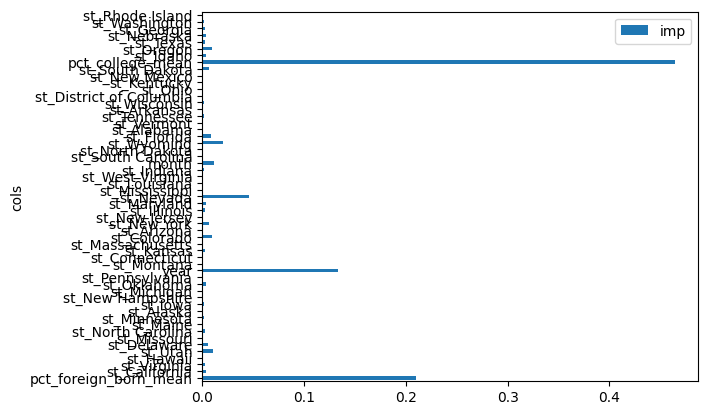

In [38]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=model.feature_importances_)).plot('cols', 'imp', 'barh');

## Submitting to Kaggle

In [ ]:
test_df = pd.read_csv(path/'test.csv')

In [ ]:
test_df['first_day_of_month'] =  pd.to_datetime(test_df['first_day_of_month'])

In [ ]:
test_df_ft = feature_engineering(test_df).drop('first_day_of_month',axis=1)

In [ ]:
test_df_ft

In [ ]:
test_xs = xs_y(test_df_ft)[0]

In [ ]:
test_df['microbusiness_density'] = model.predict(test_xs)

In [ ]:
result = test_df[['row_id','microbusiness_density']]

In [ ]:
result.to_csv('subm.csv', index=False)
!head subm.csv

Let's submit this to kaggle. We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'updated model', comp)

Success! We successfully created a submission.

## Conclusion

## Addendum

`fastkaggle` also provides a function that pushes a notebook to Kaggle Notebooks. I wrote this notebook on my own machine, and pushed it to Kaggle from there -- here's the command I used:

In [ ]:
if not iskaggle:
    push_notebook('madhaowagh', 'rf model updated',
                  title='starter notebook ',
                  file='rf_model_v1.ipynb',
                  competition=comp, private=False, gpu=False)